# Quick autodiff tutorial

Let's begin by importing some stuff:

In [63]:
from starry.grad import Map
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm
from scipy.optimize import minimize
np.random.seed(1234)

In [2]:
%matplotlib inline

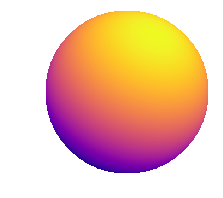

In [131]:
lmax = 1
map = Map(lmax)
map.load_image('earth')
map.show()

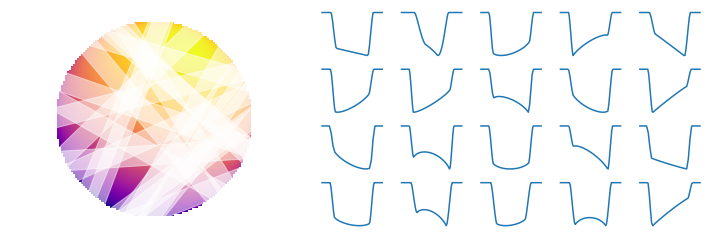

In [169]:
npts = 100
nevents = 20
ro = 0.1
np.random.seed(8765)

# Randomize occultor paths
xo = []
yo = []
theta = []
dy = []
n = 0
while n < nevents:
    ymin = 2 * np.random.random() - 1
    alpha = np.pi * np.random.random() - np.pi / 2
    x = np.linspace(-1.5, 1.5, npts)
    y = ymin + x * np.tan(alpha)
    inds = x ** 2 + y ** 2 <= 1.5 ** 2
    if len(x[inds]) > 10:
        xo.append(x[inds])
        yo.append(y[inds])
        dy.append(ro / np.cos(alpha))
        theta.append(np.ones_like(x[inds]) * np.random.random() * 2 * np.pi)
        n += 1
        
# Plot the rays the occultor traces
fig = pl.figure(figsize=(14, 4))
ax = pl.subplot2grid((3, 10), (0, 0), rowspan=3, colspan=4)
res = 100
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
I = [map.evaluate(x=x[j], y=y[j]) for j in range(res)]
ax.imshow(I, origin="lower", interpolation="none", cmap='plasma', extent=(-1, 1, -1, 1))
for i in range(nevents):
    ax.fill_between(xo[i], yo[i] - dy[i], yo[i] + dy[i], color='w', alpha=0.5)
ax.set_aspect(1)
ax.set_xlim(-1 - ro, 1 + ro);
ax.set_ylim(-1 - ro, 1 + ro);
ax.axis('off');

# Plot the light curves
axlc = np.array([[pl.subplot2grid((4, 10), (i, j)) for i in range(4)] for j in range(4, 9)]).flatten()
flux = [None for i in range(nevents)]
for i in range(nevents):
    flux[i] = map.flux(xo=xo[i], yo=yo[i], ro=ro, theta=theta[i])
    axlc[i].plot(flux[i])
    axlc[i].axis('off')

In [170]:
# Concatenate into a single dataset
xo = np.concatenate(xo)
yo = np.concatenate(yo)
theta = np.concatenate(theta)
flux = np.concatenate(flux)

In [173]:
def chisq(y, recmap, xo, yo, ro, theta, flux, sigma=0.001):
    # Assign the map coefficients
    n = 0
    for l in range(1, recmap.lmax + 1):
        for m in range(-l, l + 1):
            recmap[l, m] = y[n]
            n += 1
            
    # Compute the model and the chi-squared
    model = recmap.flux(xo=xo, yo=yo, ro=ro, theta=theta)
    chi2 = np.sum((model - flux) ** 2) / sigma ** 2
    
    # Get the derivatives of the flux w/ respect to y
    dfdy = [recmap.gradient['Y_{%d,%d}' % (l, m)] for l in range(1, recmap.lmax + 1) for m in range(-l, l + 1)]
    
    # Now compute the gradient of chi-squared with respect to y
    grad = np.sum(2 * (model - flux) * dfdy, axis=1) / sigma ** 2
    
    # Return chi squared **and** gradient
    return chi2, grad

Optimization terminated successfully.


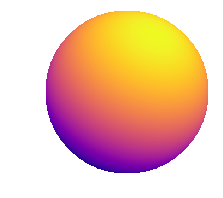

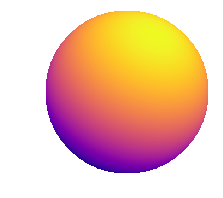

In [174]:
y = 0.1 * np.random.randn((lmax + 1) ** 2)
recmap = Map(lmax)
recmap[0, 0] = 1
res = minimize(chisq, y[1:], args=(recmap, xo, yo, ro, theta, flux), jac=True)
print(res.message)
n = 0
for l in range(1, recmap.lmax + 1):
    for m in range(-l, l + 1):
        recmap[l, m] = res.x[n]
        n += 1
map.show()
recmap.show()

In [175]:
res

      fun: 1.1685002158586237e-23
 hess_inv: array([[9.99995609e-01, 1.43760978e-03, 1.62735563e-03],
       [1.43760978e-03, 2.06738116e-06, 2.33947344e-06],
       [1.62735563e-03, 2.33947344e-06, 2.64906746e-06]])
      jac: array([ 9.40514918e-11, -8.89169735e-08,  8.26927928e-08])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([0.21652829, 0.19006597, 0.10537396])